In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

Using TensorFlow backend
TensorFlow version: 2.16.1
KerasNLP version: 0.15.1


In [2]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


In [6]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [7]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

Epoch 1/2


I0000 00:00:1731719536.592262      65 service.cc:145] XLA service 0x7d3d480061b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731719536.592321      65 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731719547.573554      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


191/191 ━━━━━━━━━━━━━━━━━━━━ 122s 508ms/step - accuracy: 0.6380 - loss: 0.6270 - val_accuracy: 0.7374 - val_loss: 0.5422
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 84s 437ms/step - accuracy: 0.7565 - loss: 0.5107 - val_accuracy: 0.7623 - val_loss: 0.5084
191/191 ━━━━━━━━━━━━━━━━━━━━ 31s 148ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step


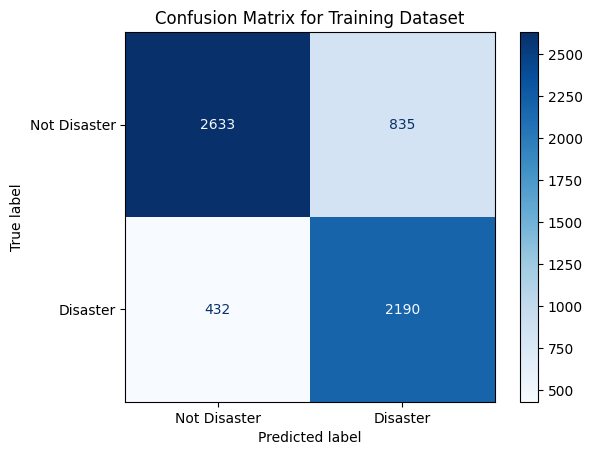

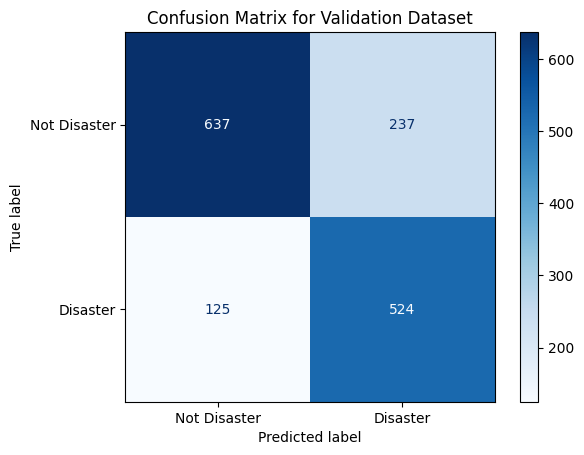

102/102 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step


In [8]:
import pandas as pd  # Import pandas for DataFrame operations
import keras_nlp
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Define the displayConfusionMatrix function
def displayConfusionMatrix(y_true, y_pred, dataset):
    """
    Displays the confusion matrix for a given dataset and predictions.
    
    Args:
    - y_true: Actual labels
    - y_pred: Predicted labels (logits)
    - dataset: Name of the dataset (e.g., "Training", "Validation")
    """
    # Convert predictions to class labels
    y_pred_classes = tf.argmax(y_pred, axis=1).numpy()

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Disaster", "Disaster"])

    # Plot the confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {dataset} Dataset")
    plt.show()

# Use the ALBERT base preset from KerasNLP
preset = "albert_base_en_uncased"

# Preprocessor for the ALBERT model
preprocessor = keras_nlp.models.AlbertPreprocessor.from_preset(
    preset,
    sequence_length=160  # Adjust based on GPU memory
)

# ALBERT Classifier
classifier = keras_nlp.models.AlbertClassifier.from_preset(
    preset,
    preprocessor=preprocessor,
    num_classes=2
)

# Compile the classifier
classifier.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(3e-5),
    metrics=["accuracy"]
)

# Train the model
history = classifier.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val)
)

# Predict and evaluate
y_pred_train = classifier.predict(X_train)
y_pred_val = classifier.predict(X_val)

# Display confusion matrices
displayConfusionMatrix(y_train, y_pred_train, "Training")
displayConfusionMatrix(y_val, y_pred_val, "Validation")

# Generate predictions for the test set
test_predictions = classifier.predict(X_test)

# Ensure test_ids are available (if provided in a separate CSV or dataset)
# Assuming test_ids are given or are part of your dataset
test_ids = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")["id"]

# Create sample_submission DataFrame using correct test_ids
sample_submission = pd.DataFrame({
    "id": test_ids,  # Use actual test IDs from the provided data
    "target": [0] * len(test_ids)  # Initialize with dummy values
})

# Update predictions in the DataFrame
sample_submission["target"] = tf.argmax(test_predictions, axis=1).numpy()

# Save to CSV
sample_submission.to_csv("submission.csv", index=False)
